In [1]:
import open3d
import numpy as np
import util
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


**1. Optimization**: You are given the function:  exp(a * x) * sin(x) + b. Implement Levenberg Marquadt using numpy and solve for the parameters of the above function. Optimize for the following parameters: a=2, b = 1. Do this for 50 observations that lie between 1 and 20. Plot the loss values over time and data fit curves. Ensure that your initial estimates are not very close to the final parameters. Write down the jacobian formula in the notebook. **\[3 points\]**

In [2]:
x_obs = np.sort(np.random.random(size=50) * 20)
y_obs = np.exp(-2 * x_obs) + 1


def lm(x, y, lr = 0.001, iters=10):
    loss = []
    k = np.array([[1.5, 12.3]]).T
    for i in range(iters):
        a, b = k[0, 0], k[1, 0]
        r = np.expand_dims(np.exp(-a * x) + b - y, axis=1)
        cur_loss = np.sum(r ** 2)
                        
        loss.append(np.sum(r ** 2))
        j = np.vstack([-np.sin(x) * np.exp(-a * x) * a, np.ones(shape=x.shape)]).T
        
        new_k = k - (np.linalg.inv(j.T @ j + lr * np.eye(j.shape[1])) @ j.T) @ r
        new_a, new_b = new_k[0, 0], new_k[1, 0]
        new_r = np.expand_dims(np.exp(-new_a * x) + new_b - y, axis=1)
        new_loss = np.sum(new_r ** 2)
        
        if new_loss < cur_loss:
            lr = lr * 2
            k = new_k
        else:
            lr = lr / 3
    
    return {'training_loss': loss, 'result': k}
    
history = lm(x_obs, y_obs)

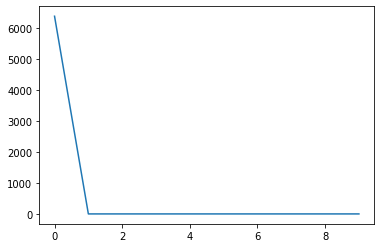

In [3]:
plt.plot(history['training_loss'])

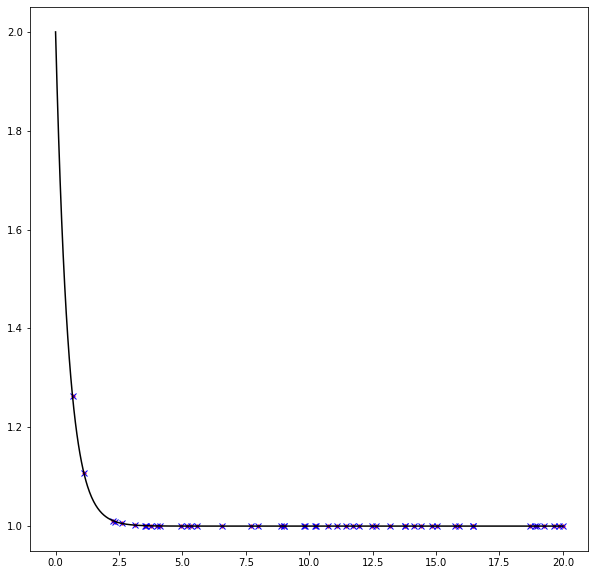

In [4]:
plt.figure(figsize=(10, 10))
plt.plot(x_obs, y_obs, 'r.')
plt.plot(x_obs, np.exp(-history['result'][0, 0] * x_obs) + history['result'][1, 0], 'bx')
x_smooth = np.linspace(0, 20, 1000)
plt.plot(x_smooth, np.exp(-history['result'][0, 0] * x_smooth) + history['result'][1, 0], 'k')
plt.show()

In [5]:
a, b = history['result'].T[0]
print(a, b)

1.99853120234826 0.9999897670680715


**2. Linear least square**: You are given a bin file from the Kitti raw sequence. Estimate the ground plane from the given bin file. After estimating the ground plane, visualize this in open3d by drawing 200-300 points on the ground with a different color on top of the plot obtained from the LiDAR scan. Use RANSAC to estimate the ground plane. Will this work without RANSAC? Why or Why not? Write down the equation of the ground plane obtained and also mention the parameters used for doing RANSAC  **\[6 points\]**

Expected result is displayed here:

![output](./data/groundplane.png)

In [6]:
def read_bin_file(file_name):
    """
    Read the bin file
    """
    points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
    points = points[:,:3]                # exclude reflectance values, becomes [X Y Z]
    points = points[1::5,:]              # remove every 5th point for display speed (optional)
    return points

In [7]:
filename = "./data/000013.bin"
points = read_bin_file(filename)

# Function used to visualize point clouds, takes a list of 3 x N numpy array as input and plots
util.visualize_pointclouds([points.T])

In [8]:
best_normal, best_distance, best_score = None, None, 99999999999999.0

for i in range(1000):
    selection = np.random.randint(len(points), size=3)
    x, y, z = points[selection]
    normal = np.cross(x - z, y - z)
    distance = np.dot(normal, x)

    distance_to_plane = np.dot(points, normal) - distance
    score = np.sqrt(np.mean(distance_to_plane ** 2))
    
    if score < best_score:
        best_score = score
        best_distance = distance
        best_normal = normal

In [9]:
n = best_normal / np.linalg.norm(best_normal)
d = best_distance / np.linalg.norm(best_distance)
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])

x = x - np.dot(n, x) * n
x = x / np.linalg.norm(x)

y = y - np.dot(n, y) * n + np.dot(x, y) * x
y = y / np.linalg.norm(y)

x_c, y_c = np.meshgrid(np.linspace(-100, 100, 50), np.linspace(-100, 100, 50))
x_c = np.reshape(x_c, -1)
y_c = np.reshape(y_c, -1)
print(np.stack([x_c, y_c]))

coords = x_c[:, None] * x[None, :] + y_c[:, None] * y[None, :] + n

# util.visualize_pointclouds([coords.T])

[[-100.          -95.91836735  -91.83673469 ...   91.83673469
    95.91836735  100.        ]
 [-100.         -100.         -100.         ...  100.
   100.          100.        ]]


In [10]:
pcd_base = open3d.geometry.PointCloud()
pcd_base.points = open3d.utility.Vector3dVector(points)
pcd_base.paint_uniform_color([56/255, 172/255, 236/255])

pcd_ground = open3d.geometry.PointCloud()
pcd_ground.points = open3d.utility.Vector3dVector(coords)
pcd_ground.paint_uniform_color([1, 0.706, 0])

open3d.visualization.draw_geometries([pcd_base, pcd_ground])

We get the following output for the ground plane.

![Output of Ground Plane Estimation](output-ransac.png)

We have performed RANSAC with 1000 iterations.